# CNNGeometric demo notebook
This notebook shows how to run a trained model on a given image pair

## Imports

In [31]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow, download_PF_pascal, download_pascal, download_caltech, download_TSS
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

from skimage import transform

warnings.filterwarnings('ignore')

## Parameters

In [32]:
#feature_extraction_cnn = 'resnet101'
feature_extraction_cnn = 'vgg'

if feature_extraction_cnn=='vgg':
    model_aff_path = 'trained_models/best_streetview_checkpoint_adam_affine_grid_loss_PAMI.pth.tar'
    model_tps_path = 'trained_models/best_streetview_checkpoint_adam_tps_grid_loss_PAMI.pth.tar'
    model_hom_path = 'trained_models/best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'
elif feature_extraction_cnn=='resnet101':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss_resnet_random.pth.tar'   

#source_image_path='datasets/PF-dataset/duck(S)/060_0036.png'
#target_image_path='datasets/PF-dataset/duck(S)/060_0013.png'

source_image_path='datasets/PF-dataset/duck(S)/060_0036.png'
target_image_path='datasets/PF-dataset/duck(S)/060_0013.png'

## Load models

In [33]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_hom = not model_hom_path==''

print(do_aff)
print(do_tps)

# Create model
print('Creating CNN model...')
if do_aff:
    #model_aff = CNNGeometric(use_cuda=use_cuda,geometric_model='affine',feature_extraction_cnn=feature_extraction_cnn)
    model_aff = CNNGeometric(use_cuda=use_cuda,output_dim=6,feature_extraction_cnn=feature_extraction_cnn)
if do_tps:
    #model_tps = CNNGeometric(use_cuda=use_cuda,geometric_model='tps',feature_extraction_cnn=feature_extraction_cnn)
    model_tps = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
if do_hom:
    model_hom = CNNGeometric(use_cuda=use_cuda,output_dim=8, feature_extraction_cnn=feature_extraction_cnn)

# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])
if do_hom:
    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc:storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_hom.load_state_dict(checkpoint['state_dict'])

True
True
Creating CNN model...
Loading trained model weights...


## Create image transformers

In [34]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

## Load and preprocess images

In [35]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [6]:
#download_PF_willow()
#download_TSS()
#download_caltech()
#download_PF_pascal()
#download_pascal()

In [27]:
orig_image = io.imread(source_image_path)

rescaled_image = transform.rescale(orig_image, 0.9)

rotated_rescaled_image = transform.rotate(rescaled_image, 15)

In [28]:
#source_image_path = 'datasets/UnimelbCorridor/10_Synthetic_HL_Untextured_Clear/img/snap_001_0001.png'
#source_image_path = 'datasets/UnimelbCorridor/pairs/s023.png'
#target_image_path = 'datasets/UnimelbCorridor/pairs/r001.png'

source_image = io.imread(source_image_path)
#source_image = rotated_resicaled_image
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Evaluate model

In [30]:
if do_aff:
    model_aff.eval()
if do_tps:
    model_tps.eval()
if do_hom:
    model_hom.eval()

# Evaluate models
if do_aff:
    theta_aff=model_aff(batch)
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))

# if do_tps:
#     theta_tps=model_tps(batch)
#     warped_image_tps = tpsTnf(batch['source_image'],theta_tps)

# if do_aff and do_tps:
#     theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
#     warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)

# if do_hom:
#     theta_hom = model_hom(batch)
#     warped_image_hom = homTnf(batch['source_image'],theta_hom)

In [ ]:
# print(feature_A.shape)
# print(feature_B.shape)
# print(correlation.shape)
# print(source_image.shape)
# A = feature_A.squeeze(0).permute(1,2,0).cpu()
# A = np.array([A[0], A[1], A[2,0]])
# A.shape
#plt.imshow(A, cmap = 'gray', vmin = 0, vmax = 255)

#plt.imshow(feature_A.permute)

## Process result

In [9]:
# Un-normalize images and convert to numpy
if do_aff:
    warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_tps:
    warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_aff and do_tps:
    warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_hom:
    warped_image_hom_np = normalize_image(resizeTgt(warped_image_hom),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()


## Display

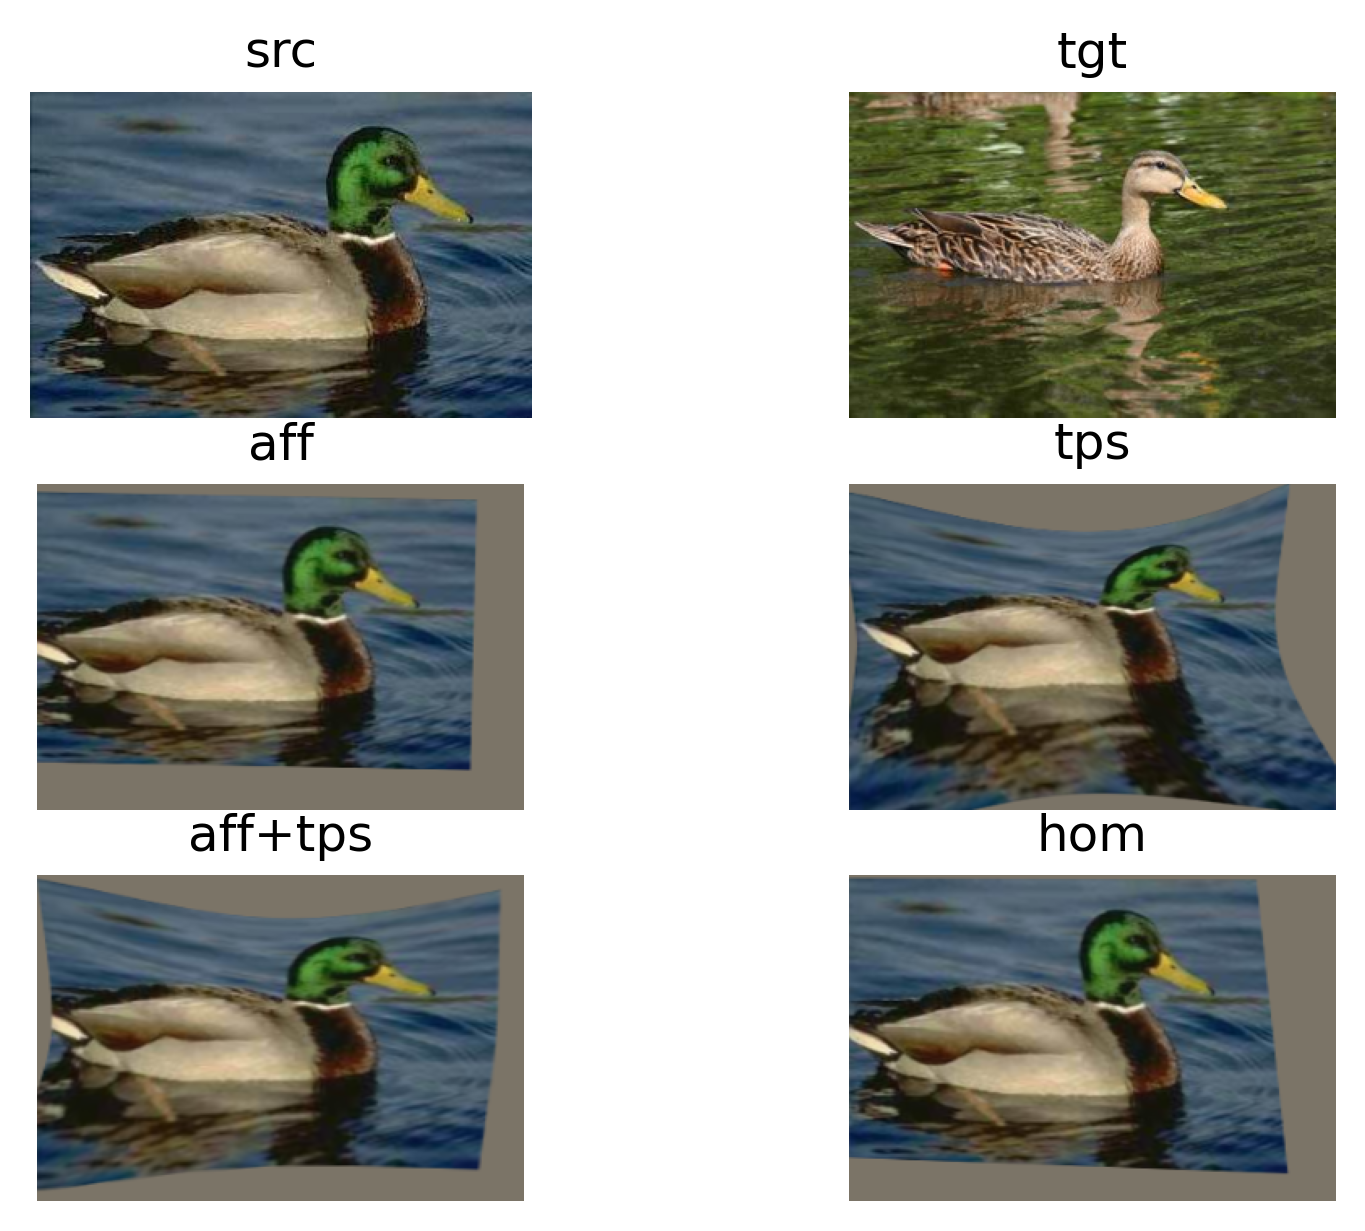

In [10]:
fig, axs = plt.subplots(3,2)
axs[0, 0].imshow(source_image)
axs[0, 0].set_title('src')
axs[0, 0].axis('off')
axs[0, 1].imshow(target_image)
axs[0, 1].set_title('tgt')
axs[0, 1].axis('off')
if do_aff:
    axs[1, 0].imshow(warped_image_aff_np)
    axs[1, 0].set_title('aff')
    axs[1, 0].axis('off')
if do_tps:
    axs[1, 1].imshow(warped_image_tps_np)
    axs[1, 1].set_title('tps')
    axs[1, 1].axis('off')
if do_aff and do_tps:
    axs[2, 0].imshow(warped_image_aff_tps_np)
    axs[2, 0].set_title('aff+tps')
    axs[2, 0].axis('off')
if do_hom:
    axs[2, 1].imshow(warped_image_hom_np)
    axs[2, 1].set_title('hom')
    axs[2, 1].axis('off')

fig.set_dpi(300)
plt.savefig("datasets/UnimelbCorridor/output/r001_s001untext.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

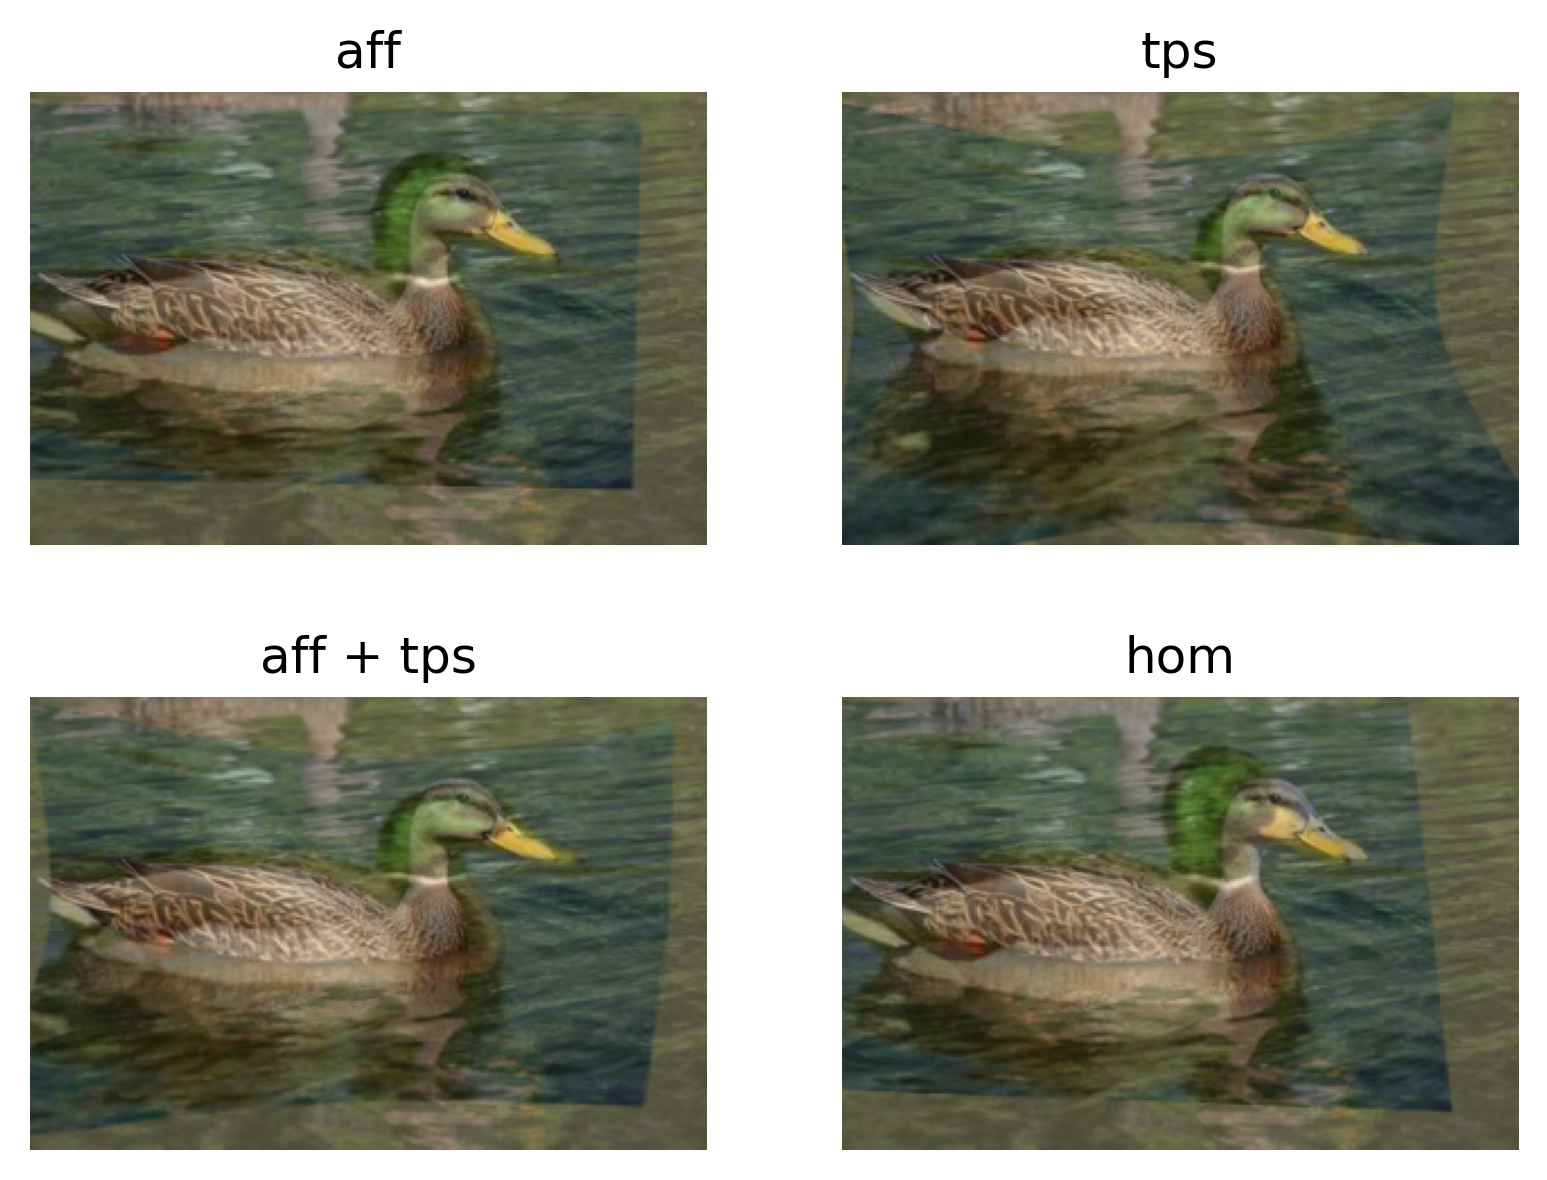

In [11]:
fig3, axs = plt.subplots(2, 2)
a = 0.5
axs[0, 0].imshow(target_image)
axs[0, 0].imshow(warped_image_aff_np, alpha = a)
axs[0, 0].set_title('aff')
axs[0, 0].axis('off')
axs[0, 1].imshow(target_image)
axs[0, 1].imshow(warped_image_tps_np, alpha = a)
axs[0, 1].set_title('tps')
axs[0, 1].axis('off')
axs[1, 0].imshow(target_image)
axs[1, 0].imshow(warped_image_aff_tps_np, alpha = a)
axs[1, 0].set_title('aff + tps')
axs[1, 0].axis('off')
axs[1, 1].imshow(target_image)
axs[1, 1].imshow(warped_image_hom_np, alpha = a)
axs[1, 1].set_title('hom')
axs[1, 1].axis('off')
fig3.set_dpi(300)
plt.savefig("datasets/UnimelbCorridor/output/r001_s001untext_overlay.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()




In [ ]:
# N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)+int(do_hom)
# fig, axs = plt.subplots(1,N_subplots)
# axs[0].imshow(source_image)
# axs[0].set_title('src')
# axs[1].imshow(target_image)
# axs[1].set_title('tgt')
# subplot_idx = 2
# if do_aff:
#     axs[subplot_idx].imshow(warped_image_aff_np)
#     axs[subplot_idx].set_title('aff')
#     subplot_idx +=1 
# if do_tps:
#     axs[subplot_idx].imshow(warped_image_tps_np)
#     axs[subplot_idx].set_title('tps')
#     subplot_idx +=1 
# if do_aff and do_tps:
#     axs[subplot_idx].imshow(warped_image_aff_tps_np)
#     axs[subplot_idx].set_title('aff+tps')
#     subplot_idx +=1
# if do_hom:
#     axs[subplot_idx].imshow(warped_image_hom)
#     axs[subplot_idx].set_title('hom')

# for i in range(N_subplots):
#     axs[i].axis('off')

# fig.set_dpi(300)
# plt.show()